In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O ./sunspots.csv

--2020-09-11 21:47:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.13.240, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘./sunspots.csv’

./sunspots.csv      100%[===================>]  69.17K  --.-KB/s    in 0.04s   

2020-09-11 21:47:18 (1.85 MB/s) - ‘./sunspots.csv’ saved [70827/70827]



In [2]:
!cat sunspots.csv

In [3]:
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

In [5]:
import csv
import numpy as np
time_step = []
sunspots = []

with open('./sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # throw the titles of columns
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))
        
series = np.array(sunspots)
time = np.array(time_step)

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    

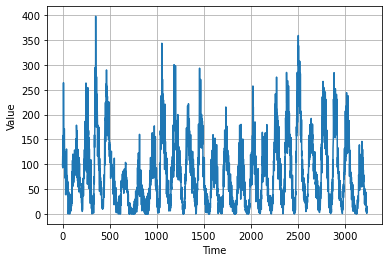

In [7]:
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

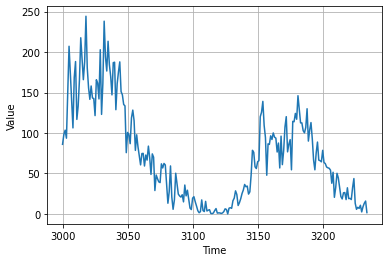

In [9]:
plot_series(time_valid, x_valid)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[1:])) # sequence-to-sequence
    return dataset.batch(batch_size).prefetch(1)

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(3000,)
Epoch 1/100
12/12 [==============================] - 3s 233ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 3s 246ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 3s 257ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 4s 305ms/step - loss: 72.2678 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 3s 291ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 3s 243ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 3s 246ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 3s 251ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 3s 234ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 3s 245ms/step - loss: 52.3436 - mae: 52.8400
Epoch 11/10

12/12 [==============================] - 3s 224ms/step - loss: 35.7855 - mae: 36.2817
Epoch 84/100
12/12 [==============================] - 3s 221ms/step - loss: 34.0215 - mae: 34.5180
Epoch 85/100
12/12 [==============================] - 3s 223ms/step - loss: 28.1070 - mae: 28.6016
Epoch 86/100
12/12 [==============================] - 3s 224ms/step - loss: 28.7773 - mae: 29.2724
Epoch 87/100
12/12 [==============================] - 3s 222ms/step - loss: 32.0800 - mae: 32.5759
Epoch 88/100
12/12 [==============================] - 3s 222ms/step - loss: 30.7360 - mae: 31.2308
Epoch 89/100
12/12 [==============================] - 3s 222ms/step - loss: 27.9740 - mae: 28.4692
Epoch 90/100
12/12 [==============================] - 3s 221ms/step - loss: 30.2404 - mae: 30.7358
Epoch 91/100
12/12 [==============================] - 3s 224ms/step - loss: 28.7434 - mae: 29.2384
Epoch 92/100
12/12 [==============================] - 3s 226ms/step - loss: 54.8850 - mae: 55.3832
Epoch 93/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

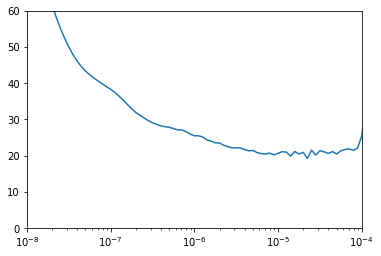

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 102ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 3s 103ms/step - loss: 25.7664 - mae: 26.2608
Epoch 3/500
30/30 [==============================] - 3s 109ms/step - loss: 22.0755 - mae: 22.5692
Epoch 4/500
30/30 [==============================] - 3s 105ms/step - loss: 20.4607 - mae: 20.9535
Epoch 5/500
30/30 [==============================] - 3s 112ms/step - loss: 19.7240 - mae: 20.2164
Epoch 6/500
30/30 [==============================] - 3s 101ms/step - loss: 19.3214 - mae: 19.8135
Epoch 7/500
30/30 [==============================] - 3s 108ms/step - loss: 18.5039 - mae: 18.9958
Epoch 8/500
30/30 [==============================] - 3s 104ms/step - loss: 18.2912 - mae: 18.7825
Epoch 9/500
30/30 [==============================] - 3s 102ms/step - loss: 18.0578 - mae: 18.5492
Epoch 10/500
30/30 [==============================] - 3s 102ms/step - loss: 18.0667 - mae: 18.5581
Epoch 11/500
30/30 

30/30 [==============================] - 3s 97ms/step - loss: 16.3481 - mae: 16.8362
Epoch 85/500
30/30 [==============================] - 3s 97ms/step - loss: 16.3913 - mae: 16.8800
Epoch 86/500
30/30 [==============================] - 3s 98ms/step - loss: 16.8127 - mae: 17.3016
Epoch 87/500
30/30 [==============================] - 3s 98ms/step - loss: 16.6436 - mae: 17.1325
Epoch 88/500
30/30 [==============================] - 3s 101ms/step - loss: 16.4543 - mae: 16.9435
Epoch 89/500
30/30 [==============================] - 3s 101ms/step - loss: 16.6717 - mae: 17.1603
Epoch 90/500
30/30 [==============================] - 3s 100ms/step - loss: 16.3899 - mae: 16.8781
Epoch 91/500
30/30 [==============================] - 3s 100ms/step - loss: 16.4112 - mae: 16.9000
Epoch 92/500
30/30 [==============================] - 3s 102ms/step - loss: 16.3507 - mae: 16.8389
Epoch 93/500
30/30 [==============================] - 3s 107ms/step - loss: 16.3682 - mae: 16.8570
Epoch 94/500
30/30 [=======

30/30 [==============================] - 3s 101ms/step - loss: 15.8849 - mae: 16.3735
Epoch 167/500
30/30 [==============================] - 3s 100ms/step - loss: 15.9187 - mae: 16.4073
Epoch 168/500
30/30 [==============================] - 3s 101ms/step - loss: 16.1300 - mae: 16.6188
Epoch 169/500
30/30 [==============================] - 3s 101ms/step - loss: 15.9451 - mae: 16.4336
Epoch 170/500
30/30 [==============================] - 3s 102ms/step - loss: 15.9805 - mae: 16.4692
Epoch 171/500
30/30 [==============================] - 3s 102ms/step - loss: 16.0847 - mae: 16.5735
Epoch 172/500
30/30 [==============================] - 3s 100ms/step - loss: 15.8315 - mae: 16.3200
Epoch 173/500
30/30 [==============================] - 3s 102ms/step - loss: 15.8619 - mae: 16.3506
Epoch 174/500
30/30 [==============================] - 3s 100ms/step - loss: 16.0115 - mae: 16.5001
Epoch 175/500
30/30 [==============================] - 3s 104ms/step - loss: 15.9145 - mae: 16.4030
Epoch 176/500


30/30 [==============================] - 3s 116ms/step - loss: 15.6369 - mae: 16.1247
Epoch 249/500
30/30 [==============================] - 3s 112ms/step - loss: 15.9750 - mae: 16.4639
Epoch 250/500
30/30 [==============================] - 3s 107ms/step - loss: 15.5925 - mae: 16.0803
Epoch 251/500
30/30 [==============================] - 3s 106ms/step - loss: 15.5041 - mae: 15.9916
Epoch 252/500
30/30 [==============================] - 3s 99ms/step - loss: 15.5561 - mae: 16.0438
Epoch 253/500
30/30 [==============================] - 3s 97ms/step - loss: 15.4650 - mae: 15.9523
Epoch 254/500
30/30 [==============================] - 3s 100ms/step - loss: 15.4737 - mae: 15.9615
Epoch 255/500
30/30 [==============================] - 3s 101ms/step - loss: 15.4822 - mae: 15.9697
Epoch 256/500
30/30 [==============================] - 3s 98ms/step - loss: 15.4432 - mae: 15.9307
Epoch 257/500
30/30 [==============================] - 3s 106ms/step - loss: 15.4228 - mae: 15.9103
Epoch 258/500
30/

30/30 [==============================] - 3s 101ms/step - loss: 15.1518 - mae: 15.6387
Epoch 331/500
30/30 [==============================] - 3s 111ms/step - loss: 15.1334 - mae: 15.6203
Epoch 332/500
30/30 [==============================] - 3s 103ms/step - loss: 15.0830 - mae: 15.5696
Epoch 333/500
30/30 [==============================] - 3s 106ms/step - loss: 15.1776 - mae: 15.6648
Epoch 334/500
30/30 [==============================] - 3s 112ms/step - loss: 15.0445 - mae: 15.5309
Epoch 335/500
30/30 [==============================] - 3s 107ms/step - loss: 15.0996 - mae: 15.5860
Epoch 336/500
30/30 [==============================] - 3s 101ms/step - loss: 15.1793 - mae: 15.6662
Epoch 337/500
30/30 [==============================] - 3s 103ms/step - loss: 15.1373 - mae: 15.6243
Epoch 338/500
30/30 [==============================] - 3s 101ms/step - loss: 15.2142 - mae: 15.7008
Epoch 339/500
30/30 [==============================] - 3s 102ms/step - loss: 15.0934 - mae: 15.5799
Epoch 340/500


30/30 [==============================] - 3s 100ms/step - loss: 14.9587 - mae: 15.4454
Epoch 413/500
30/30 [==============================] - 3s 97ms/step - loss: 14.7939 - mae: 15.2793
Epoch 414/500
30/30 [==============================] - 3s 100ms/step - loss: 14.8440 - mae: 15.3299
Epoch 415/500
30/30 [==============================] - 3s 97ms/step - loss: 15.0417 - mae: 15.5279
Epoch 416/500
30/30 [==============================] - 3s 100ms/step - loss: 14.9403 - mae: 15.4267
Epoch 417/500
30/30 [==============================] - 3s 98ms/step - loss: 14.7901 - mae: 15.2760
Epoch 418/500
30/30 [==============================] - 3s 98ms/step - loss: 14.9037 - mae: 15.3899
Epoch 419/500
30/30 [==============================] - 3s 98ms/step - loss: 14.7233 - mae: 15.2091
Epoch 420/500
30/30 [==============================] - 3s 98ms/step - loss: 14.8521 - mae: 15.3383
Epoch 421/500
30/30 [==============================] - 3s 98ms/step - loss: 14.9089 - mae: 15.3952
Epoch 422/500
30/30 [

30/30 [==============================] - 3s 96ms/step - loss: 14.6811 - mae: 15.1676
Epoch 495/500
30/30 [==============================] - 3s 99ms/step - loss: 14.5471 - mae: 15.0326
Epoch 496/500
30/30 [==============================] - 3s 96ms/step - loss: 14.4865 - mae: 14.9718
Epoch 497/500
30/30 [==============================] - 3s 98ms/step - loss: 14.4994 - mae: 14.9847
Epoch 498/500
30/30 [==============================] - 3s 96ms/step - loss: 14.4892 - mae: 14.9746
Epoch 499/500
30/30 [==============================] - 3s 97ms/step - loss: 14.5336 - mae: 15.0192
Epoch 500/500
30/30 [==============================] - 3s 99ms/step - loss: 14.9150 - mae: 15.4014


In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
# print(np.shape(forecast))
forecast = forecast[split_time - window_size:-1, -1, 0]

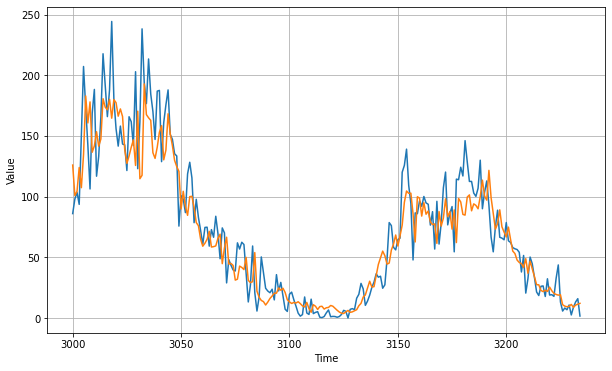

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

15.765759

<Figure size 432x288 with 0 Axes>

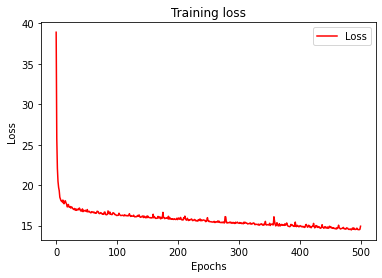

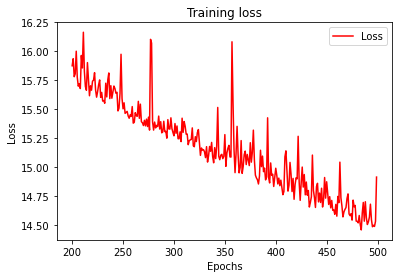

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()